This vignette demonstrates how to estimate spatial autocorrelation from residuals of multiple regression across the Western US ecoregion groups in the absence of any spatial sub-sampling

First, we will load the necessary packages to run the code

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
#
# Author: Lewis Kunik - University of Utah
# Contact: lewis.kunik@utah.edu
#

#%%
#########################################
# Load packages
#########################################

# File system packages
import os  # operating system library
import sys
import glob
from pathlib import Path
import copy

# numerical/data management packages
import numpy as np
import xarray as xr 
import pandas as pd

# shapefile/geospatial packages
import geopandas as gpd
from shapely.geometry import mapping
from shapely.geometry import Point

# Stats packages
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

# time and date packages
import time
from datetime import datetime as dt  # date time library
from datetime import timedelta

# Standard plotting packages
from matplotlib import pyplot as plt  # primary plotting module
from matplotlib.ticker import FuncFormatter as FFmt  # need this for formatting plot ticks

# Geospatial plotting packages
import cartopy.crs as ccrs  # cartopy is the best spatial plotting library i know
from cartopy.io import img_tiles  # cartopy's implementation of webtiles
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature




Define any global filepaths and variables that will be needed throughout the script 

In [2]:

#########################################
# Define Global Filepaths
#########################################

dat_basedir = '/uufs/chpc.utah.edu/common/home/lin-group19/ltk/SIF/SIF_IAV/data/'
dat_dir_precip = '/uufs/chpc.utah.edu/common/home/lin-group19/ltk/SIF/SIF_IAV/data/TOT_WY_Precip'
EPA_ecoregion_dir = '/uufs/chpc.utah.edu/common/home/lin-group23/ltk/EPA/ecoregions/'
EPA_ecoregion_L2_file = os.path.join(EPA_ecoregion_dir, 'L2', 'WUS_cec_eco_l2.shp')

########################################
# Define Global Variables and constants
#########################################

# Define the averaging window definition for "annual" values
timing_label = 'FULL_YEAR' # options: "FULL_YEAR", "TOP_QUARTILE", "POST_PEAK_LAI", "PRE_PEAK_LAI"
dat_dir = os.path.join(dat_basedir, timing_label)  # directory where data files are stored, based on timing_label

## Define paths to data files
TROPOMI_SIF_file = glob.glob(f'{dat_dir}/TROPOMI_SIF*.nc')[0]

MODIS_NDVI_file = glob.glob(f'{dat_dir}/MODIS_MOD13A2_NDVI*.nc')[0]
MODIS_EVI_file = glob.glob(f'{dat_dir}/MODIS_MOD13A2_EVI*.nc')[0]
MODIS_NDMI_file = glob.glob(f'{dat_dir}/MODIS_MCD43A4_NDMI*.nc')[0]
MODIS_NIRv_file = glob.glob(f'{dat_dir}/MODIS_MCD43A4_NIRv*.nc')[0]
MODIS_LAI_file = glob.glob(f'{dat_dir}/MODIS_MOD15A2H_LAI*.nc')[0]
MODIS_LST_file = glob.glob(f'{dat_dir}/MODIS_MYD21A2_LST*.nc')[0]
GRIDMET_PDSI_file = glob.glob(f'{dat_dir}/GRIDMET_PDSI*.nc')[0]
GRIDMET_Tmax_file = glob.glob(f'{dat_dir}/GRIDMET_Tmax*.nc')[0]
GRIDMET_Tmin_file = glob.glob(f'{dat_dir}/GRIDMET_Tmin*.nc')[0]
GRIDMET_VPD_file = glob.glob(f'{dat_dir}/GRIDMET_VPD*.nc')[0]
GRIDMET_Precip_file = glob.glob(f'{dat_dir_precip}/GRIDMET_TotWYPrecip*.nc')[0]
TerraClimate_CWD_file = glob.glob(f'{dat_dir}/TerraClimate_CWD*.nc')[0]
TerraClimate_SoilM_file = glob.glob(f'{dat_dir}/TerraClimate_SoilM*.nc')[0]
nClimGrid_SPEI_01_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_01*.nc')[0]
nClimGrid_SPEI_02_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_02*.nc')[0]
nClimGrid_SPEI_03_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_03*.nc')[0]
nClimGrid_SPEI_06_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_06*.nc')[0]
nClimGrid_SPEI_09_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_09*.nc')[0]
nClimGrid_SPEI_12_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_12*.nc')[0]
nClimGrid_SPEI_24_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_24*.nc')[0]
nClimGrid_SPEI_36_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_36*.nc')[0]
nClimGrid_SPEI_48_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_48*.nc')[0]
nClimGrid_SPEI_60_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_60*.nc')[0]
nClimGrid_SPEI_72_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_72*.nc')[0]

#########################################
# Set plotting parameters
#########################################

plt.rcParams.update({
   'axes.labelsize': 16,
   'axes.titlesize': 16,
   'xtick.labelsize': 16,
   'ytick.labelsize': 15,
   'legend.fontsize': 13,
})

# use Google Satellite imagery as basemap
tiler = img_tiles.GoogleTiles(style='satellite')
crs = tiler.crs # set crs of map tiler
alpha = 0.8  # transparency 0-1
transform = ccrs.PlateCarree()  # transform specifies the crs that the data is in

tiler_zoom = 7  # define a zoom level of detail
extent = [-125.3, -102.7, 29.7, 50.3]  # [minx, maxx, miny, maxy], bounds for map

### Load state boundaries
fn = shpreader.natural_earth(
   resolution='10m', category='cultural', 
   name='admin_1_states_provinces',
)
reader = shpreader.Reader(fn)
states = [x for x in reader.records() if x.attributes["admin"] == "United States of America"] # get all states in US
states_geom = cfeature.ShapelyFeature([x.geometry for x in states], ccrs.PlateCarree())

# matplotlib map plotting functions
def z_axis_formatter(x, pos, deci=2):
   '''Format ticks to format with deci number of decimals'''

   return f'{x:.{deci}f}'



Define any functions that will be needed throughout the script

In [3]:
#########################################
# Define Global Functions
#########################################

# -----------------------------------------------------------------------
# Function to load xarray data and set CRS
# -----------------------------------------------------------------------
def load_xr(dat_xr_file, varname = None):
    if varname is not None:
        dat_xr = xr.open_dataset(dat_xr_file, decode_coords='all').sortby(['x', 'y'], ascending = True)[varname]
    else:
        dat_xr = xr.open_dataset(dat_xr_file, decode_coords='all').sortby(['x', 'y'], ascending = True)
    dat_xr.rio.write_crs(4326, inplace=True)
    return dat_xr


def xarray_to_long_df(da_dict, response_var_name):
    """
    Convert dictionary of xarray DataArrays to long format DataFrame
    suitable for mixed effects modeling
    """
    # Start with response variable - only keep essential coordinates
    response_da = da_dict[response_var_name]
    df = response_da.to_dataframe(name=response_var_name).reset_index()
    
    # Keep only the columns we need for merging and analysis
    essential_cols = ['x', 'y', response_var_name]
    if 'year' in df.columns:
        essential_cols.append('year')
    
    df = df[essential_cols].dropna(subset=[response_var_name])
    
    # Add explanatory variables one by one
    for var_name, da in da_dict.items():
        if var_name != response_var_name:
            # Convert to dataframe and keep only essential columns
            var_df = da.to_dataframe(name=var_name).reset_index()
            
            # Keep only coordinates and the variable of interest
            var_essential_cols = ['x', 'y', var_name]
            if 'year' in var_df.columns:
                var_essential_cols.append('year')
            
            var_df = var_df[var_essential_cols].dropna(subset=[var_name])
            
            # Handle time-invariant variables (no year dimension)
            if 'year' not in var_df.columns and 'year' in df.columns:
                # Replicate time-invariant data for each year
                years = df['year'].unique()
                var_df_expanded = []
                for year in years:
                    temp_df = var_df.copy()
                    temp_df['year'] = year
                    var_df_expanded.append(temp_df)
                var_df = pd.concat(var_df_expanded, ignore_index=True)
            
            # Determine merge columns
            merge_cols = ['x', 'y']
            if 'year' in var_df.columns:
                merge_cols.append('year')
                
            # Merge with main dataframe
            df = df.merge(var_df, on=merge_cols, how='inner')
    
    return df



# -----------------------------------------------------------------------
# Function to calculate empirical semivariogram
# -----------------------------------------------------------------------
def calculate_semivariogram(residuals, distances, n_bins=20, max_distance=None):
    """
    Calculate empirical semivariogram from residuals and distances
    
    Parameters:
    -----------
    residuals : array
        Residual values for each location
    distances : array
        Pairwise distances (condensed form from pdist)
    n_bins : int
        Number of distance bins
    max_distance : float
        Maximum distance to consider (if None, uses max distance)
    
    Returns:
    --------
    bin_centers : array
        Center of each distance bin
    semivariance : array
        Semivariance for each bin
    counts : array
        Number of pairs in each bin
    """
    
    # Get pairwise differences in residuals
    n = len(residuals)
    resid_diff = []
    
    for i in range(n):
        for j in range(i+1, n):
            resid_diff.append((residuals[i] - residuals[j])**2)
    
    resid_diff = np.array(resid_diff)
    
    # Set max distance if not provided
    if max_distance is None:
        max_distance = distances.max()
    
    # Create distance bins
    bins = np.linspace(0, max_distance, n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Calculate semivariance for each bin
    semivariance = np.zeros(n_bins)
    counts = np.zeros(n_bins)
    
    for i in range(n_bins):
        # Find pairs within this distance bin
        mask = (distances >= bins[i]) & (distances < bins[i+1])
        
        if mask.sum() > 0:
            # Semivariance = 0.5 * mean of squared differences
            semivariance[i] = 0.5 * resid_diff[mask].mean()
            counts[i] = mask.sum()
    
    return bin_centers, semivariance, counts


Load all the relevant pre-aggregated annual files, including:
- TROPOMI SIF
- GRIDMET climate reanalysis data
- MODIS remote sensing data
- Drought indices from nClimGrid, TerraClimate, GRIDMET

Note that all datasets have been spatially regridded to 0.05° grid resolution

In [4]:
# -----------------------------------------------------------------------
# Function to load xarray data and set CRS
# -----------------------------------------------------------------------
def load_xr(dat_xr_file, varname = None):
    if varname is not None:
        dat_xr = xr.open_dataset(dat_xr_file, decode_coords='all').sortby(['x', 'y'], ascending = True)[varname]
    else:
        dat_xr = xr.open_dataset(dat_xr_file, decode_coords='all').sortby(['x', 'y'], ascending = True)
    dat_xr.rio.write_crs(4326, inplace=True)
    return dat_xr
    
###### Load all the files as xarray dataarrays
TROPOMI_SIF_xr = load_xr(TROPOMI_SIF_file, 'sifdc') # TROPOMI SIF

GRIDMET_Tmax_xr = load_xr(GRIDMET_Tmax_file, 'air_temperature') # GRIDMET Tmax
GRIDMET_Tmin_xr = load_xr(GRIDMET_Tmin_file, 'air_temperature') # GRIDMET Tmin
GRIDMET_VPD_xr = load_xr(GRIDMET_VPD_file, 'mean_vapor_pressure_deficit') # GRIDMET VPD
GRIDMET_Precip_xr = load_xr(GRIDMET_Precip_file, 'precipitation_amount') # GRIDMET Precipitation
TerraClimate_SoilM_xr = load_xr(TerraClimate_SoilM_file, 'soil') # TerraClimate Soil Moisture

# Remote sensing vegetation indices files
MODIS_NDVI_xr = load_xr(MODIS_NDVI_file, 'NDVI') # MODIS NDVI
MODIS_NDMI_xr = load_xr(MODIS_NDMI_file, 'NDMI') # MODIS NDMI
MODIS_NIRv_xr = load_xr(MODIS_NIRv_file, 'NIRv') # MODIS NIRv
MODIS_LAI_xr = load_xr(MODIS_LAI_file, 'LAI') # MODIS LAI
MODIS_LST_xr = load_xr(MODIS_LST_file, 'LST_Day') # MODIS LST

# Drought index files
GRIDMET_PDSI_xr = load_xr(GRIDMET_PDSI_file, 'pdsi') # GRIDMET PDSI
TerraClimate_CWD_xr = load_xr(TerraClimate_CWD_file, 'def') # TerraClimate CWD
nClimGrid_SPEI_01_xr = load_xr(nClimGrid_SPEI_01_file, 'SPEI_pearson') # nClimGrid SPEI 01
nClimGrid_SPEI_02_xr = load_xr(nClimGrid_SPEI_02_file, 'SPEI_pearson') # nClimGrid SPEI 02
nClimGrid_SPEI_03_xr = load_xr(nClimGrid_SPEI_03_file, 'SPEI_pearson') # nClimGrid SPEI 03
nClimGrid_SPEI_06_xr = load_xr(nClimGrid_SPEI_06_file, 'SPEI_pearson') # nClimGrid SPEI 06
nClimGrid_SPEI_09_xr = load_xr(nClimGrid_SPEI_09_file, 'SPEI_pearson') # nClimGrid SPEI 09
nClimGrid_SPEI_12_xr = load_xr(nClimGrid_SPEI_12_file, 'SPEI_pearson') # nClimGrid SPEI 12
nClimGrid_SPEI_24_xr = load_xr(nClimGrid_SPEI_24_file, 'SPEI_pearson') # nClimGrid SPEI 24
nClimGrid_SPEI_36_xr = load_xr(nClimGrid_SPEI_36_file, 'SPEI_pearson') # nClimGrid SPEI 36
nClimGrid_SPEI_48_xr = load_xr(nClimGrid_SPEI_48_file, 'SPEI_pearson') # nClimGrid SPEI 48
nClimGrid_SPEI_60_xr = load_xr(nClimGrid_SPEI_60_file, 'SPEI_pearson') # nClimGrid SPEI 60
nClimGrid_SPEI_72_xr = load_xr(nClimGrid_SPEI_72_file, 'SPEI_pearson') # nClimGrid SPEI 72  

# Climate Standardized anomaly files
# GRIDMET_Tmax_SA_xr = load_xr(GRIDMET_Tmax_SA_file, '__xarray_dataarray_variable__') # GRIDMET Tmax Standardized Anomaly
# GRIDMET_Tmin_SA_xr = load_xr(GRIDMET_Tmin_SA_file, '__xarray_dataarray_variable__') # GRIDMET Tmin Standardized Anomaly
# GRIDMET_VPD_SA_xr = load_xr(GRIDMET_VPD_SA_file, '__xarray_dataarray_variable__') # GRIDMET VPD Standardized Anomaly
# GRIDMET_Precip_SA_xr = load_xr(GRIDMET_Precip_SA_file, '__xarray_dataarray_variable__') # GRIDMET Precipitation Standardized Anomaly
# TerraClimate_SoilM_SA_xr = load_xr(TerraClimate_SoilM_SA_file, '__xarray_dataarray_variable__') # TerraClimate Soil Moisture Standardized Anomaly



### Load in ecoregion data

In [5]:
# Load EPA L2 Ecoregion file and define individual region geometries
ecoregion_l2_gdf = gpd.read_file(EPA_ecoregion_L2_file)

print("Unique ecoregion names:")
print(ecoregion_l2_gdf.NA_L2NAME.unique())
Region1_name = 'MARINE WEST COAST FOREST'
Region2_name = 'WESTERN CORDILLERA'
Region3_name = 'UPPER GILA MOUNTAINS'
ecoregion_l2_gdf_Region1 = ecoregion_l2_gdf[ecoregion_l2_gdf.NA_L2NAME == Region1_name]
ecoregion_l3_geom_Region1 = ecoregion_l2_gdf_Region1.geometry

ecoregion_l2_gdf_Region2 = ecoregion_l2_gdf[ecoregion_l2_gdf.NA_L2NAME == Region2_name]
ecoregion_l3_geom_Region2 = ecoregion_l2_gdf_Region2.geometry

ecoregion_l2_gdf_Region3 = ecoregion_l2_gdf[ecoregion_l2_gdf.NA_L2NAME == Region3_name]
ecoregion_l3_geom_Region3 = ecoregion_l2_gdf_Region3.geometry


region_names = ['Southwest', 'West', 'Marine']

# List of region geometries and names
region_geoms = [
    ecoregion_l3_geom_Region3, ecoregion_l3_geom_Region2, ecoregion_l3_geom_Region1
]

Unique ecoregion names:
['COLD DESERTS' 'WARM DESERTS' 'MEDITERRANEAN CALIFORNIA'
 'WESTERN SIERRA MADRE PIEDMONT' 'UPPER GILA MOUNTAINS'
 'WESTERN SIERRA MADRE' 'WESTERN PACIFIC COASTAL PLAIN, HILLS AND CANYONS'
 'WESTERN CORDILLERA' 'MARINE WEST COAST FOREST' 'TEMPERATE PRAIRIES'
 'WEST-CENTRAL SEMIARID PRAIRIES' 'SOUTH CENTRAL SEMIARID PRAIRIES'
 'TAMAULIPAS-TEXAS SEMIARID PLAIN']


### Visualize the data

Let's plot some maps of the datasets just to understand their patterns.

Note that there are valid pixels shown for any pixel that has >50% Evergreen Needleleaf Forest

But not all pixels shown will fall into the ecoregion areas used in this analysis

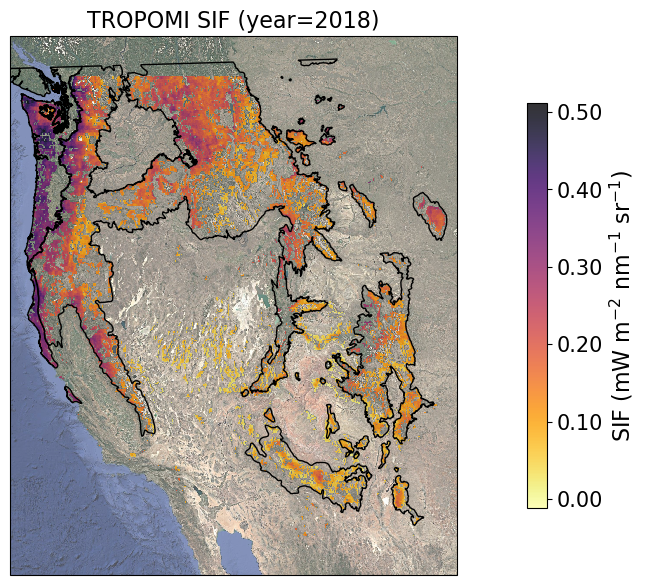

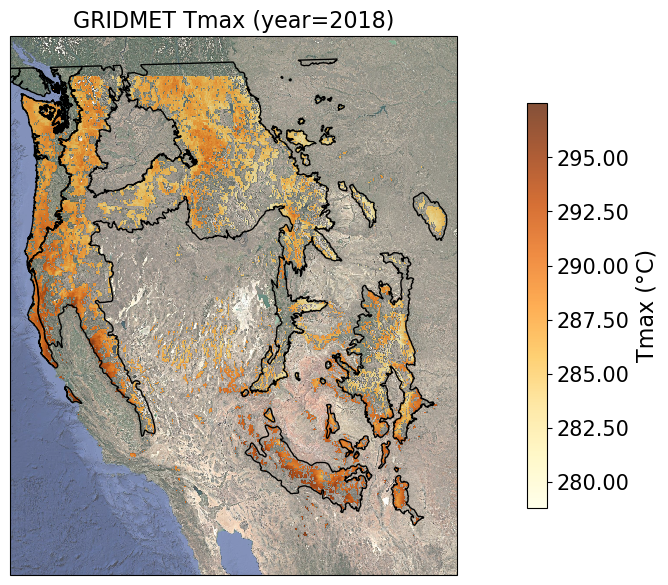

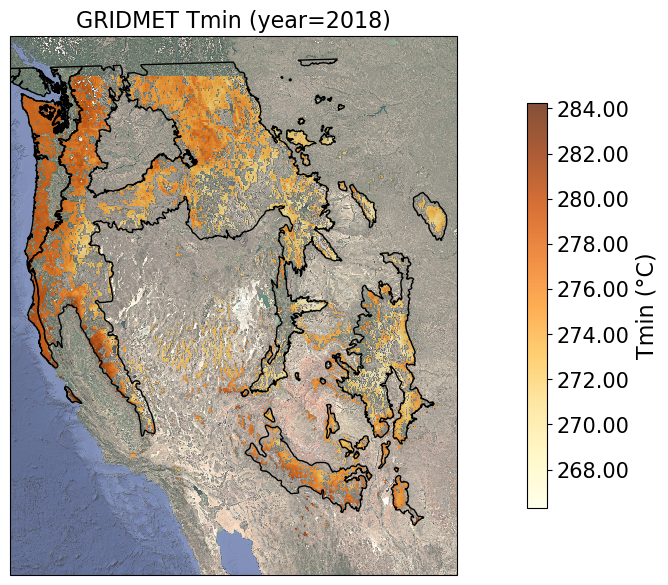

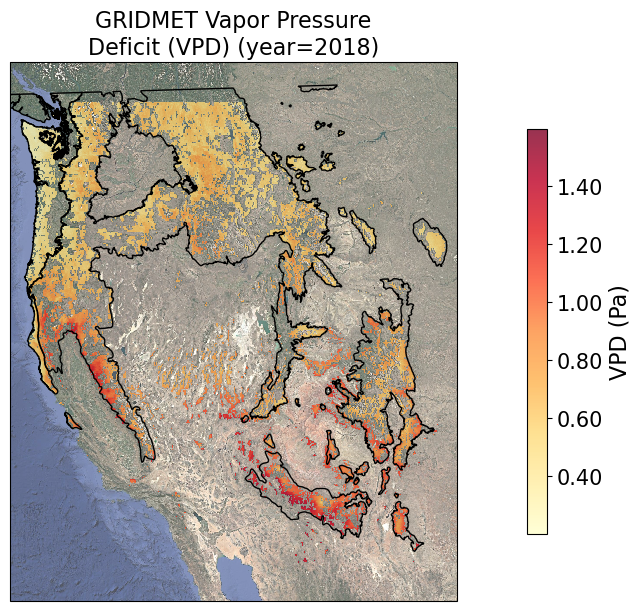

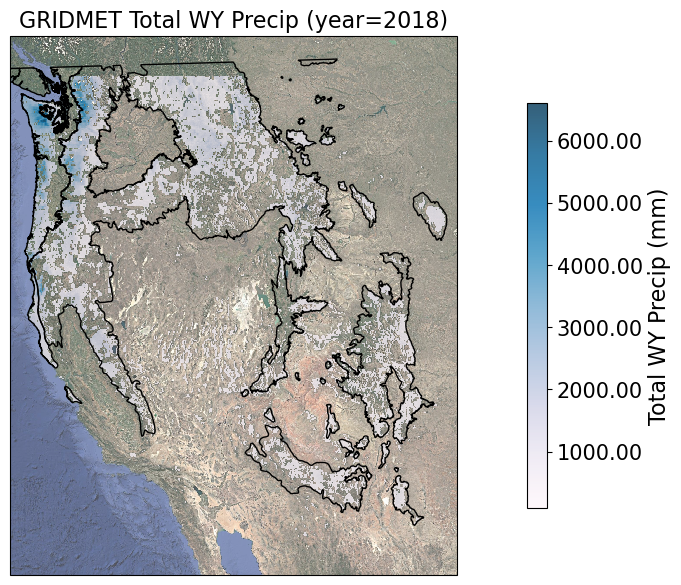

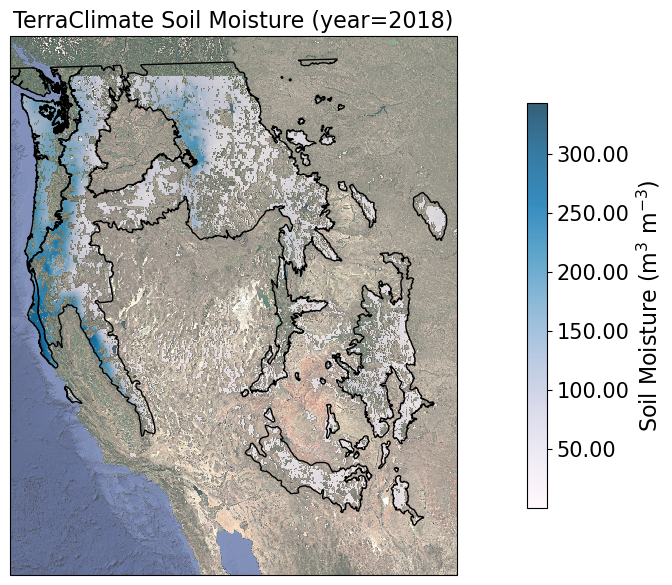

In [7]:
def plot_dataarray_map(dat_da, plotTitle, zax_label, plot_min=None, plot_max=None, cmap='inferno_r'):
    if plot_min is None:
        plot_min = np.nanmin(dat_da.values)
    if plot_max is None:
        plot_max = np.nanmax(dat_da.values)
    fig, ax = plt.subplots(subplot_kw={'projection': crs}, figsize=(9, 7)) # establish the figure, axes
    # Set extent of map before adding base img
    ax.set_extent(extent, crs=ccrs.PlateCarree())  # PlateCarree is default lat/lon
    ax.add_image(tiler, tiler_zoom, interpolation='none', alpha=0.7) # Add base image

    dat_da.plot(ax=ax, transform=transform, alpha=alpha,
                    cmap=cmap, vmin = plot_min, vmax = plot_max,
                        cbar_kwargs={'orientation': 'vertical',
                                            'pad': 0.1,
                                            'label': zax_label,
                                            'shrink': 0.75,
                                            'format': FFmt(z_axis_formatter)})

    # add state/ecoregion boundaries to the map
    # ax.add_feature(states_geom, facecolor="none", edgecolor="black", linewidth=1)
    ax.add_geometries(ecoregion_l3_geom_Region1, crs=transform, facecolor="none", edgecolor='black', linewidth=1)
    ax.add_geometries(ecoregion_l3_geom_Region2, crs=transform, facecolor="none", edgecolor='black', linewidth=1)
    ax.add_geometries(ecoregion_l3_geom_Region3, crs=transform, facecolor="none", edgecolor='black', linewidth=1)

    plt.title(plotTitle) # set axis title
    plt.show()


plot_dataarray_map(TROPOMI_SIF_xr.isel(year=0), 'TROPOMI SIF (year=2018)', 
    'SIF (mW m$^{-2}$ nm$^{-1}$ sr$^{-1}$)')

plot_dataarray_map(GRIDMET_Tmax_xr.isel(year=0), 'GRIDMET Tmax (year=2018)', 
    'Tmax (°C)', cmap='YlOrBr')

plot_dataarray_map(GRIDMET_Tmin_xr.isel(year=0), 'GRIDMET Tmin (year=2018)', 
    'Tmin (°C)', cmap='YlOrBr')

plot_dataarray_map(GRIDMET_VPD_xr.isel(year=0), 'GRIDMET Vapor Pressure\nDeficit (VPD) (year=2018)', 
    'VPD (Pa)', cmap='YlOrRd')

plot_dataarray_map(GRIDMET_Precip_xr.isel(year=0), 'GRIDMET Total WY Precip (year=2018)', 
    'Total WY Precip (mm)', cmap='PuBu')

plot_dataarray_map(TerraClimate_SoilM_xr.isel(year=0), 'TerraClimate Soil Moisture (year=2018)', 
    'Soil Moisture (m$^3$ m$^{-3}$)', cmap='PuBu')


### Simple regression and Semivariogram analyses

For each regression, we will calculate the semivariogram from the residuals
This will show us roughly at what euclidean distances the pixel pairs' residuals are correlated, and at what distances they are not correlated. The semivariogram plots below will also show a horizontal dashed line representing the overall variance of the residuals. This is shown for reference as a potential way to estimate the threshold distance where variance between pairs is similar to that of the full set of residuals.

### NOTE:
Because we're considering multiple variables (with different residuals) we will take the average semivariance for each distance pair on the x axis below



Ecoregion group: Southwest
Modeling variable: NDVI
Modeling variable: NDMI
Modeling variable: NIRv
Modeling variable: LAI
Modeling variable: LST
Modeling variable: Tmax
Modeling variable: Tmin
Modeling variable: VPD
Modeling variable: Precip
Modeling variable: SoilM
Modeling variable: PDSI
Modeling variable: CWD
Modeling variable: SPEI_03
Modeling variable: SPEI_06
Modeling variable: SPEI_09
Modeling variable: SPEI_12
Modeling variable: SPEI_24


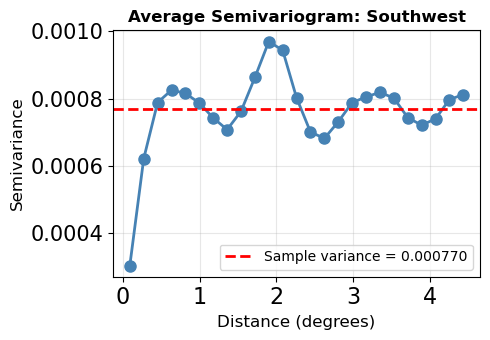


Ecoregion group: West
Modeling variable: NDVI
Modeling variable: NDMI
Modeling variable: NIRv
Modeling variable: LAI
Modeling variable: LST
Modeling variable: Tmax
Modeling variable: Tmin
Modeling variable: VPD
Modeling variable: Precip
Modeling variable: SoilM
Modeling variable: PDSI
Modeling variable: CWD
Modeling variable: SPEI_03
Modeling variable: SPEI_06
Modeling variable: SPEI_09
Modeling variable: SPEI_12
Modeling variable: SPEI_24


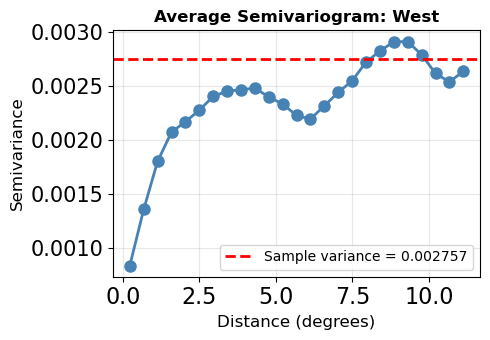


Ecoregion group: Marine
Modeling variable: NDVI
Modeling variable: NDMI
Modeling variable: NIRv
Modeling variable: LAI
Modeling variable: LST
Modeling variable: Tmax
Modeling variable: Tmin
Modeling variable: VPD
Modeling variable: Precip
Modeling variable: SoilM
Modeling variable: PDSI
Modeling variable: CWD
Modeling variable: SPEI_03
Modeling variable: SPEI_06
Modeling variable: SPEI_09
Modeling variable: SPEI_12
Modeling variable: SPEI_24


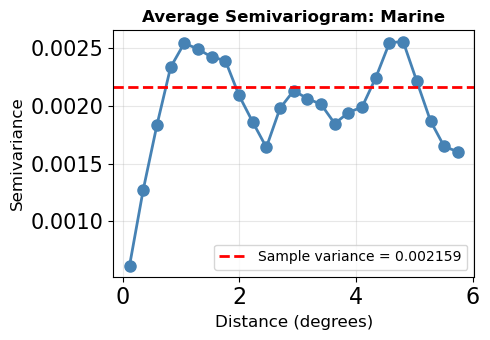

In [20]:
# Create an array of the xarray variables to test as covariates
# Create an array of the xarray variables to test as covariates
covariate_xr_arr = [MODIS_NDVI_xr, MODIS_NDMI_xr, MODIS_NIRv_xr, MODIS_LAI_xr, 
    MODIS_LST_xr, GRIDMET_Tmax_xr, GRIDMET_Tmin_xr, GRIDMET_VPD_xr, 
    GRIDMET_Precip_xr, TerraClimate_SoilM_xr, GRIDMET_PDSI_xr, 
    TerraClimate_CWD_xr, nClimGrid_SPEI_03_xr, nClimGrid_SPEI_06_xr, 
    nClimGrid_SPEI_09_xr, nClimGrid_SPEI_12_xr, nClimGrid_SPEI_24_xr]
covariate_names = ['NDVI', 'NDMI', 'NIRv', 'LAI', 'LST', 'Tmax', 'Tmin', 
    'VPD', 'Precip', 'SoilM','PDSI', 'CWD', 'SPEI_03', 'SPEI_06', 'SPEI_09', 
    'SPEI_12', 'SPEI_24']

for ii, region_geom in enumerate(region_geoms):

    
    region_name = region_names[ii]
    print(f"\nEcoregion group: {region_name}")
    covariate_results = {}
    mean_variance_arr = []

    for covariate_xr, covariate_name in zip(covariate_xr_arr, covariate_names):

        print(f"Modeling variable: {covariate_name}")
        model_results = {}
        xr_data_dict = {
            'SIF': TROPOMI_SIF_xr.rio.clip(region_geom.geometry, drop=True),
            covariate_name: covariate_xr.rio.clip(region_geom.geometry, drop=True),
        }

        df_long = xarray_to_long_df(xr_data_dict, 'SIF')
        key_vars = ['SIF', covariate_name]

        # Add pixel_id, longitude, latitude
        df_long['pixel_id'] = df_long['x'].astype(str) + '_' + df_long['y'].astype(str)
        df_long['longitude'] = df_long['x']
        df_long['latitude'] = df_long['y']

        # Clean up - remove rows with missing values in key variables
        df_model = df_long.dropna(subset=key_vars).copy()

        # Standardize predictors
        all_predictors = [covariate_name]
        df_standardized = df_model.copy()
        df_standardized[all_predictors] = StandardScaler().fit_transform(df_model[all_predictors])

        # Fit multilinear regression model
        formula = f'SIF ~ {covariate_name}'
        try:
            model = smf.ols(formula, data=df_standardized)
            result = model.fit()
            model_results['full_result'] = result
            model_results['coeff'] = result.params[covariate_name]
        except Exception as e:
            print(f"Model fitting failed: {e}")

        # Simple R² for OLS
        model_results['r2'] = result.rsquared
        model_results['r2_adj'] = result.rsquared_adj

        # AIC and BIC are directly available
        model_results['AIC'] = result.aic
        model_results['BIC'] = result.bic

        covariate_results[covariate_name] = model_results

        # Get residuals from the model
        residuals = model_results['full_result'].resid

        # Create DataFrame with residuals and spatial info
        resid_df = df_standardized[['pixel_id', 'x', 'y', 'year']].copy()
        resid_df['residual'] = residuals.values

        # Get pixel-level mean residuals (averaged across years)
        pixel_resid = resid_df.groupby('pixel_id').agg({
            'x': 'first',
            'y': 'first', 
            'residual': 'mean'
        }).reset_index()

        # Extract coordinates
        coords = pixel_resid[['x', 'y']].values

        # Calculate Euclidean distances (in degrees)
        # For more accurate distances, you could convert to meters using geopy
        distances = pdist(coords, metric='euclidean')

        # Convert to square matrix for easier indexing
        distance_matrix = squareform(distances)

        # Calculate empirical variogram
        # Limit to reasonable max distance (e.g., half the max distance)
        max_dist = distance_matrix.max() / 2

        bin_centers, semivariance, pair_counts = calculate_semivariogram(
            pixel_resid['residual'].values,
            distances,
            n_bins=25,
            max_distance=max_dist
        )

        # Filter out bins with too few pairs
        min_pairs = 30
        valid_bins = pair_counts >= min_pairs

        covariate_results[covariate_name] = semivariance

        mean_variance_arr.append(pixel_resid['residual'].var())


    # Calculate mean semivariance across all covariates for each distance bin
    mean_semivariance = np.mean([covariate_results[cov_name] for cov_name in covariate_names], axis=0)
    mean_variance = np.mean(mean_variance_arr)

    #########################################
    # Plot empirical variogram
    #########################################
    fig, ax = plt.subplots(figsize=(5, 3.5))

    # Plot 1: Semivariogram
    ax.plot(bin_centers[valid_bins], mean_semivariance[valid_bins], 
            'o-', markersize=8, linewidth=2, color='steelblue')
    ax.axhline(y=mean_variance, 
                color='red', linestyle='--', linewidth=2,
                label=f'Sample variance = {mean_variance:.6f}')
    ax.set_xlabel('Distance (degrees)', fontsize=12)
    ax.set_ylabel('Semivariance', fontsize=12)
    ax.set_title(f'Average Semivariogram: {region_name}', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.legend(fontsize=10)
    plt.tight_layout()
    plt.show()







### Interpreting the semivariogram

For this regression analysis of SIF vs. climate variables, each ecoregion seems to have a similar semivariogram shape. Ultimately, we will select a representative sampling distance based on these results, but this is where we exercise some interpretation and logical reasoning. For example, even if the semivariogram intersects the full residual variance line at a distance of 2 degrees, we may still want to sample pixels closer together so that our linear regression model has a sufficient number of points for analysis.

## TL;DR - Overall impressions

### Gila Mountains ("Southwest")
Residuals appear to be largely uncorrelated at a distance of around 0.5 degrees

### Western Cordillera ("West")
Residuals appear to be largely uncorrelated at a distance of around 1.5-2 degrees (roughly)
- Sampling may need to be closer in order to maintain sufficient points for regression

### Marine (Coastal) Montane
Residuals appear to be largely uncorrelated at a distance of around 0.5-0.75 degrees